# Laboratorio 1
### Security Data Science
- Christian Pérez
- Andrei Portales

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

In [2]:
df = pd.read_csv('dataset_pishing.csv')
df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
df['status'].value_counts()


legitimate    5715
phishing      5715
Name: status, dtype: int64

Funciones para detectar pishing:
- longitud del hostname y URL completa
- Caracteres especiales en los dominios y subdominios
- No contar con certificado SSL
- Muchos numeros en las URL

In [7]:
from urllib.parse import urlparse

# Function to get lenght of URL
def get_url_length(url):
    return len(url)

def get_hostname_length(url):
    return len(urlparse(url).netloc)

# Funtion to get if https is present in URL
def get_https(url):
    if 'https' in url:
        return 1
    else:
        return 0

# Function to get if there are the following characters in URL: ., -, @, /, ?, &, |, =, _, ~, #, %, $, :, *, ,, ;, , %%!
def get_special_characters(url):
    if re.search(r'[.,@/?&|=~#%$:*;,! ]', url):
        return 0
    else:
        return 1

# Function to get number of digits in URL
def get_digits(url):
    return len(re.findall(r'\d', url))

# Function to get number of digits in hostname
def get_digits_hostname(url):
    return len(re.findall(r'\d', urlparse(url).netloc))


In [11]:
new_df = df.copy()
new_df['url_length'] = new_df['url'].apply(get_url_length)
new_df['hostname_length'] = new_df['url'].apply(get_hostname_length)
new_df['https'] = new_df['url'].apply(get_https)
new_df['special_characters'] = new_df['url'].apply(get_special_characters)
new_df['digits'] = new_df['url'].apply(get_digits)
new_df['digits_hostname'] = new_df['url'].apply(get_digits_hostname)
new_df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,dns_record,google_index,page_rank,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,1,1,4,legitimate,37,19,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,0,1,2,phishing,77,23,0,0,17,0
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,0,1,0,phishing,126,50,1,0,19,0
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,0,0,3,legitimate,18,11,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,0,6,legitimate,55,15,0,0,0,0


In [12]:
# Change the values of the status column to 0 and 1
new_df['status'] = new_df['status'].map({'legitimate': 1, 'phishing': 0})
new_df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,dns_record,google_index,page_rank,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,1,1,4,1,37,19,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,0,1,2,0,77,23,0,0,17,0
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,0,1,0,0,126,50,1,0,19,0
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,0,0,3,1,18,11,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,0,6,1,55,15,0,0,0,0


In [14]:
# Delete the url column
new_df = new_df.drop('url', axis=1)
new_df.head()

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,dns_record,google_index,page_rank,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,0,1,0,0,0,0,0,0,0,0,...,1,1,4,1,37,19,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,2,0,77,23,0,0,17,0
2,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,126,50,1,0,19,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,3,1,18,11,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,6,1,55,15,0,0,0,0


Summarize dataset:  99%|█████████▉| 1103/1109 [01:27<00:00, 11.06it/s, Missing diagram bar]                                          c:\Users\Christian\Documents\python_env\data_sciece_env\lib\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
c:\Users\Christian\Documents\python_env\data_sciece_env\lib\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (72).')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:

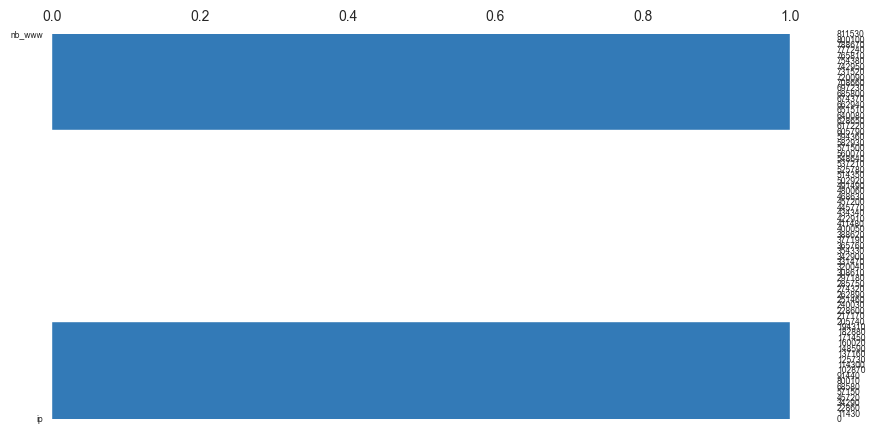

In [15]:
import pandas_profiling
# save the report to a html file
pandas_profiling.ProfileReport(new_df).to_file('report.html')



In [17]:
# new dataframe with only status, url_length, hostname_length, https, special_characters, digits and digits_hostname
df2 = new_df[['status', 'url_length', 'hostname_length', 'https', 'special_characters', 'digits', 'digits_hostname']]
df2.head()

,status,url_length,hostname_length,https,special_characters,digits,digits_hostname
0,1,37,19,0,0,0,0
1,0,77,23,0,0,17,0
2,0,126,50,1,0,19,0
3,1,18,11,0,0,0,0
4,1,55,15,0,0,0,0


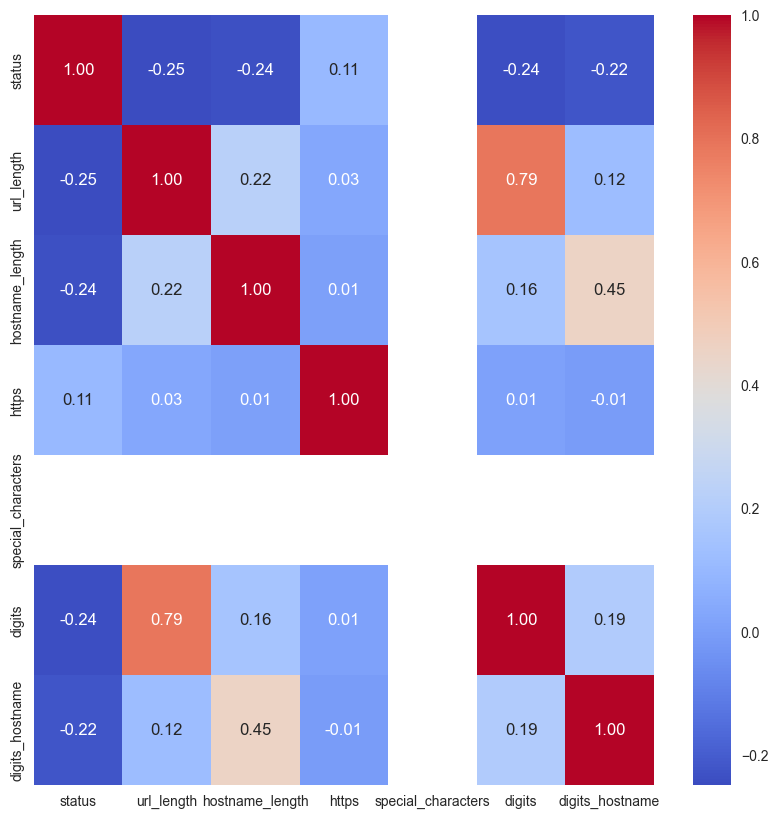

In [19]:
# Draw a heatmap with the correlation matrix
corr = df2.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()